# Optical Image Crystal Growth Rate Calculator
This notebook is used to find areal and facet growth rates for single crystals from optical microscopy images. The data is assumed to be h5py files but the functions can be used once images (as 2D float32 arrays), timestamps, and a scale are fed in.

## Useful imports

In [1]:
import hyperspy.api as hs                 # hyperspectral data processing and some useful image viewing
import h5py                               # to handle .h5 files
from matplotlib import pyplot as plt      # Plotting
import numpy as np                        # Maths
import cv2                                # Image analysis
from os import walk                       # To get filepaths automatically
from natsort import natsorted             # To easily resort file order
from datetime import datetime             # For easily parsing timestamps
import warnings
warnings.filterwarnings("ignore")         # Attempt to remove some unnecessary pyplot warnings
import optical_image_functions as oif

## Folder Selection

In [2]:
folder = r'C:\Users\es758\Documents\Python Scripts\Mini 1\Reflection data subset\\'

Can inspect the structure of the files by running the below code.

In [3]:
# fpaths = oif.get_filepaths(folder)
# fpath=fpaths[0]
# oif.get_h5py_contents(fpath)

## Image Data Extraction

In [4]:
# Some base code for the below is all in test_notebook
# Plot times by using a to be made plotting function?
# Plot specific image function?
# Plot hs time series function?
# backend maplotlib chooser like George?

Extracting images and timestamps using suggested function which truncates series if a large discontinuity in timestamp is detected.

In [5]:
ts, images, pixel_size = oif.get_data_h5py(folder)

## Image Pre-Processing

Should check if working for data set of interest and tailor accordingly.

In [6]:
# plot contours could be adapted from test notebook too to incldue scale etc.
# should plot areas too to check if preprocessing working
# Need to make plotting functions to investigate quality of pre-processing for purpose.
# should I provide a manual contour selection too to allow checking of estimate? Or can just use scale to say how much image frame is.

In [ ]:
# inspecting code probably would use some of
def plot_contours(cnts,im,title=None):
    """ Takes contours and an image, and plots them both"""
    plt.figure()
    cols = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
    for i in range(len(cnts)):
        plt.scatter(cnts[i][:,0][:][:,0],cnts[i][:,0][:][:,1],s=2,color=cols[i%len(cols)],alpha=0.4)
        plt.imshow(im,cmap='gray')
    if title != None:
        plt.title(title,fontsize=15)
    plt.axis('off')
    plt.show()

# %matplotlib qt
# i=22
# image=[images[i]]
# contour_sets, area_sets, perim_sets = get_contour_data(image)
# plot_contours(contour_sets[0], get_binary(image[0]))

In [7]:
def get_binary(im):
    """
    Suggested image pre-processing to produce a binary that can get good estimates of crystal area from an image. 
    @param im: a 2D float32 array
    @return binary: a 2D array of uint8 values of 1s and 0s. 
    Pre-processing can heavily influence the quality of the area estimates and should be tailored to specific sets of images.
    Use plotting functions I have made to investigate 
    Things to consider include:
        Changing the order or presence of image pre-processing operations
        Change the size of kernels from the default values suggested in optical_image_functions
        Avoid causing area values to collapse by making the edge around the crystal discontinuous
        Avoid having a binary that effectively has a shell in the outline
    Use https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html as a guide for what some of the operations do.
    Note that some of the image examples may not apply as expected depending on at which stage the operations are applied (e.g. opening base image rather than the threshold or sobel).
    """
    im1 = oif.blur_image(im)
    im1=oif.close_image(im1, 8) # changing the kernel size to 8 was found to improve the end binary in this case.
    im1=oif.open_image(im1)
    im1=oif.sobel_2D(im1)
    binary=oif.threshold_image(im1)
    return binary

In [8]:
binary_images=[get_binary(im) for im in images]

## Crystal Area by Contour Extraction
Contour extraction for area estimation assumes a single large crystal growing entirely in the field of view. More than one or any at the edges will be dodgy. Are these problems I can get around without ML or something?

In [10]:
contour_sets, area_sets, perim_sets = oif.get_contour_data(binary_images)

In [11]:
def extract_best_contour_data(contour_sets, area_sets, perim_sets):
    """
    For now, best just means biggest area. Area was found to be a bit more stable than perimeter.
    """
    best_contours = []
    best_areas = []
    best_perims = []
    for i in np.arange(len(contour_sets)):
        criterion = np.max(area_sets[i]) # Just takes the biggest contour
        best_areas.append(criterion)
        j = area_sets[i].index(criterion)
        best_contours.append(contour_sets[i][j])
        best_perims.append(perim_sets[i][j])
    return best_contours, best_areas, best_perims

def clean_area_data(contour_series, area_series, time_series, step_factor=100):
    """
    Maybe change in future to make a bit more lenient. Also problem finding partly relies on contours getting confused when the edge is reached.
    """
    cleaned_area_series = []
    index_list = np.arange(len(area_series))
    NaNcounter=0 # Counter used to track how many NaNs in total
    for i in index_list:
        if i == 0 or i == index_list[-1]:
            cleaned_area_series.append(area_series[i])
        elif i == 1:
            cleaned_area_series.append(area_series[i])
         # Check if something has gone wrong with area estimate
        elif abs(area_series[i]-cleaned_area_series[i-1]) > step_factor*abs(cleaned_area_series[i-1]-cleaned_area_series[i-2]):
            # Check if area value collapsed probably without recovery, likely due to crystal reaching edge of frame
            if area_series[i+1] < cleaned_area_series[i-1]: # Perhaps it is a bit harsh, but checks by seeing if 2 in a row a problem
                break
            # If next entry is fine, replace with a NaN and move on
            else:
                cleaned_area_series.append(np.NaN)
                NaNcounter += 1
        # If everything is fine, just add the area to the cleaned list
        else:
            cleaned_area_series.append(area_series[i])   
    cleaned_time_series = time_series[:len(cleaned_area_series)]
    cleaned_contour_series = contour_series[:len(cleaned_area_series)]
    if NaNcounter > len(cleaned_area_series)*0.33:
            print("More than a third of area data entries in cleaned range are dodgy")
    return cleaned_contour_series, cleaned_area_series, cleaned_time_series

In [12]:
best_contours, best_areas, best_perims = extract_best_contour_data(contour_sets, area_sets, perim_sets)
cleaned_contour_series, cleaned_area_series, cleaned_time_series = clean_area_data(best_contours, best_areas, ts)

Convert area by pixel into better units and calculate growth rates

In [14]:
crystal_area_series = np.array(cleaned_area_series)*pixel_size*pixel_size
crystal_time_series = cleaned_time_series
crystal_area_growth_rates = oif.extract_area_growth_rate(crystal_area_series, crystal_time_series) 

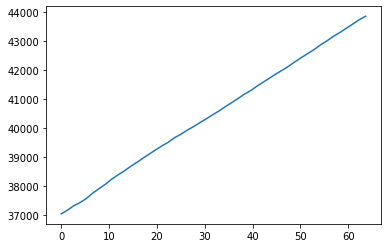

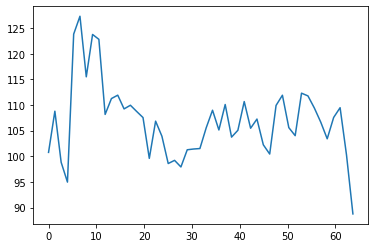

In [15]:
%matplotlib inline
plt.plot(crystal_time_series, crystal_area_series)
plt.show()
plt.plot(crystal_time_series, crystal_area_growth_rates)
plt.show()

## Facet Growth Rate

Funnily enough, should be fine for crystal not entirely being in frame initially. Will probably have trouble if more than one crystal though due to mixed signals. Might have to find way of segmenting etc in future?

In [12]:
def rotate_image(im, angle):
    row, col = im.shape
    image_centre = tuple(np.array([row, col])/2)
    rot_mat = cv2.getRotationMatrix2D(image_centre, angle, 1.0)
    result = cv2.warpAffine(im, rot_mat, (col, row), flags=cv2.INTER_LINEAR) # warpAffine takes shape in reverse order
    return result

# note that if I rotate before taking sobel filter of image, the black corners of no data will stand out very brightly from the sobel.

def onedimify(im):
    #row, col = im.shape
    im_1D_av = []
    for row in im:
        im_1D_av.append(np.average(row))
    return im_1D_av

def find_alignment(im, step_degree=1):
    angles = np.arange(0, 90+step_degree, step_degree) # if only allow 90 degrees won't necessarily find the alignement with the 
    # longest face because it doesn't rotate back, I've tried. Need to let it do 180 degrees.
    # better to do this than not know which it is finding? Or maybe if end up extracting growth rate both directions then doesn't matter
    biggest_signals = []
    for angle in angles:
        rotated_image = rotate_image(im, angle)
        onedim = onedimify(rotated_image)
        biggest_signals.append(np.max(onedim))
    best_alignment = angles[biggest_signals.index(np.max(biggest_signals))]
    return best_alignment

54


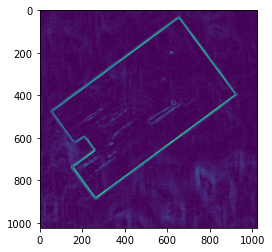

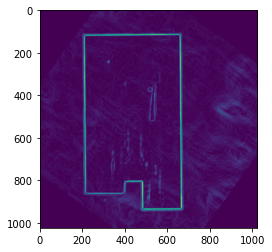

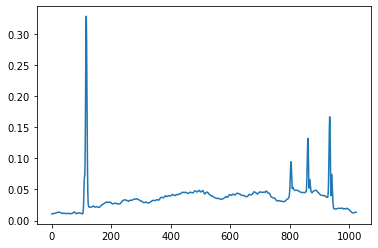

In [16]:
image_test=images[0].copy()
sobel = oif.sobel_2D(oif.open_image(oif.blur_image(image_test)))
print(find_alignment(sobel, 1))
plt.imshow(sobel)
plt.show()
plt.imshow(rotate_image(sobel, 54))
plt.show()
plt.plot(onedimify(rotate_image(sobel, 54)))

In [63]:
rotated_images = []
onedimified_images=[]
for im in images:
    sobel=oif.sobel_2D(oif.open_image(oif.blur_image(im)))
    rot_sobel = rotate_image(sobel, 54)
    onedimified_images.append(onedimify(rot_sobel))
    rotated_images.append(rot_sobel)
print("done")
# note for future that sobel has to be applied before rotation or corners turn up weird.

done


In [64]:
%matplotlib qt
s = hs.signals.Signal2D(rotated_images)
s.plot()

In [65]:
onedim = hs.signals.Signal1D(onedimified_images)
onedim.plot()

  0%|          | 0/1 [00:00<?, ?it/s]

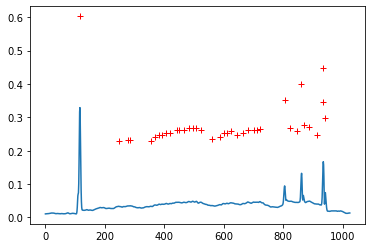

In [87]:
%matplotlib inline
a= onedimified_images[0]
s = hs.signals.Signal1D(a)
peaks = s.find_peaks1D_ohaver()

plt.plot(a)
position = [i[0] for i in peaks[0]]
height = [i[1] for i in peaks[0]]
plt.plot(position, height, 'r+')
plt.show()

find_peaks1D_ohaver(xdim=None, slope_thresh=0, amp_thresh=None, subchannel=True, medfilt_radius=5, maxpeakn=30000, peakgroup=10, parallel=None, max_workers=None)

‘slope_thresh’ and ‘amp_thresh’, control sensitivity: higher values will neglect broad peaks (slope) and smaller features (amp), respectively.

peakgroup is the number of points around the top of the peak that are taken to estimate the peak height. For spikes or very narrow peaks, set peakgroup to 1 or 2; for broad or noisy peaks, make peakgroup larger to reduce the effect of noise.

  0%|          | 0/1 [00:00<?, ?it/s]

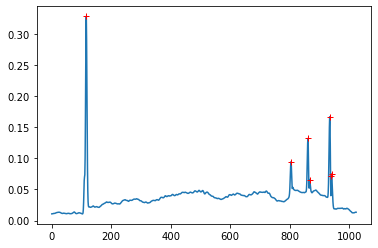

In [115]:
%matplotlib inline
a= onedimified_images[0]
s = hs.signals.Signal1D(a)
#peaks = s.find_peaks1D_ohaver(peakgroup=2)
#peaks = s.find_peaks1D_ohaver(slope_thresh=0.001)
#peaks = s.find_peaks1D_ohaver(amp_thresh=0.05)
peaks = s.find_peaks1D_ohaver(peakgroup=2,slope_thresh=0.001)
plt.plot(a)
position = [i[0] for i in peaks[0]]
height = [i[1] for i in peaks[0]]
plt.plot(position, height, 'r+')
plt.show()

## Me worrying about hyperspectral data and the geometry it has in it

C:\Users\es758\University of Cambridge\Alice Dearle - mini1 hyper-perov\example 2 hyperspectral\090321\\Untitled(1)(1).h5
26
560.0


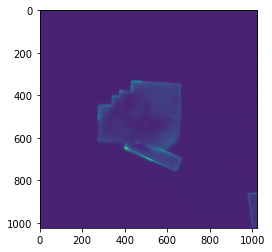

In [49]:


folder=r'C:\Users\es758\University of Cambridge\Alice Dearle - mini1 hyper-perov\example 2 hyperspectral\090321\\'
fpaths = oif.get_filepaths(folder)
fpath=fpaths[0]
print(fpath)
f = h5py.File(fpath,'r')
# Extract the image
print(len(f['Cube/Images']))
print(f['Cube/Wavelength'][-1])
image = f['Cube/Images'][24]
# Convert format for wider compatibility   
image = np.array(image).astype('float32') # converts to 2D array with float32 values
# wavelengths
#488 to 582
# 510 to 560
%matplotlib inline
plt.imshow(image)